In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as pl

from sklearn.model_selection import cross_validate # for cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

##############################################
# Funções para converter e reverter a escala 
###

def scale01(x):
    return (x - x.min())/(x.max() - x.min())

def unscale01(x, lower, upper):
    #return (x * (upper - lower)) + lower
    return (x * upper) - ((x - 1.0) * lower)

#############################################

In [3]:

# Leitura dos dados
df = pd.read_csv('trainning.data', delimiter=';')

data = np.array(df.values[: , 2:], dtype = float)   # Pandas dtype = object, logo tudo é permitido
(N, d) = data.shape

print(N, 'x', d)


120618 x 7


In [5]:
# Primeiro, agregar de várias fontes e fazer alinhamento entre os dados
# Neste caso nada a fazer

# Segundo, fazer alguns pre-processamentos: Scaling? missing rows? missing values? outliers?

# Scaling

# keep to revert numbers back to the original range and scale
minv = data.min(0)
maxv = data.max(0)

print(data.min(0))
print(data.max(0))

for var in range(1, 7):
    data[:, var] = scale01(data[:, var])

print()
print(data.min(0))
print(data.max(0))

# Reverter para a escala e gama original 
#data2 = data.copy()
#for var in range(1, 7):
#    data2[:, var] = unscale01(data[:, var], minv[var], maxv[var])
#
#print(data2.min(0))
#print(data2.max(0))

# missing rows não é problema
# missing values?
print()
print(np.isfinite(data[:,0]).all())


[0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1.]

[0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1.]

True


In [5]:
# Para fazer uma análise visual, vamos extrair uma amostra mais pequena para a execução ser mais rápida

rng = np.random.default_rng()
subset = np.sort(rng.choice(N, int(N * 0.3)))

visdata = data[subset, :]


In [6]:
walk = np.where(visdata[:, 0] == 0)
run = np.where(visdata[:, 0] == 1)

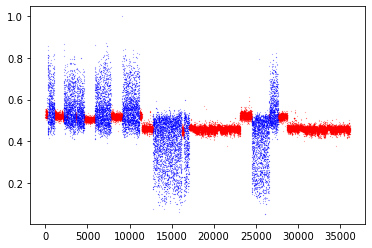

In [7]:
pl.plot(walk, visdata[walk, 1], 'r.', markersize=0.25);
pl.plot(run, visdata[run, 1], 'b.', markersize=0.25);

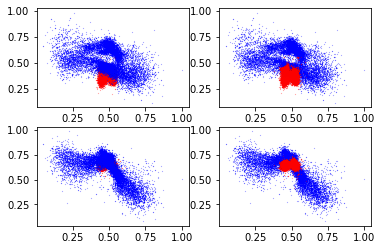

In [8]:
pl.subplot(221)
pl.plot(visdata[walk, 1], visdata[walk, 2], 'r.', markersize=0.25);
pl.plot(visdata[run, 1], visdata[run, 2], 'b.', markersize=0.25);
pl.subplot(222)
pl.plot(visdata[run, 1], visdata[run, 2], 'b.', markersize=0.25);
pl.plot(visdata[walk, 1], visdata[walk, 2], 'r.', markersize=0.25);
pl.subplot(223)
pl.plot(visdata[walk, 1], visdata[walk, 3], 'r.', markersize=0.25);
pl.plot(visdata[run, 1], visdata[run, 3], 'b.', markersize=0.25);
pl.subplot(224)
pl.plot(visdata[run, 1], visdata[run, 3], 'b.', markersize=0.25);
pl.plot(visdata[walk, 1], visdata[walk, 3], 'r.', markersize=0.25);
pl.show()

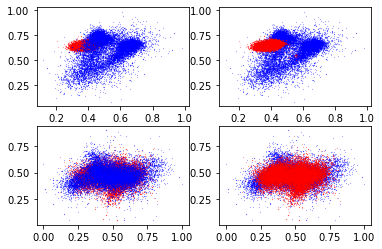

In [9]:
pl.subplot(221)
pl.plot(visdata[walk, 2], visdata[walk, 3], 'r.', markersize=0.25);
pl.plot(visdata[run, 2], visdata[run, 3], 'b.', markersize=0.25);
pl.subplot(222)
pl.plot(visdata[run, 2], visdata[run, 3], 'b.', markersize=0.25);
pl.plot(visdata[walk, 2], visdata[walk, 3], 'r.', markersize=0.25);
pl.subplot(223)
pl.plot(visdata[walk, 4], visdata[walk, 5], 'r.', markersize=0.25);
pl.plot(visdata[run, 4], visdata[run, 5], 'b.', markersize=0.25);
pl.subplot(224)
pl.plot(visdata[run, 4], visdata[run, 5], 'b.', markersize=0.25);
pl.plot(visdata[walk, 4], visdata[walk, 5], 'r.', markersize=0.25);
pl.show()

In [10]:
pl.subplot(221)
pl.plot(visdata[walk, 4], visdata[walk, 6], 'r.', markersize=0.25);
pl.plot(visdata[run, 4], visdata[run, 6], 'b.', markersize=0.25);
pl.subplot(222)
pl.plot(visdata[run, 4], visdata[run, 6], 'b.', markersize=0.25);
pl.plot(visdata[walk, 4], visdata[walk, 6], 'r.', markersize=0.25);
pl.subplot(223)
pl.plot(visdata[walk, 5], visdata[walk, 6], 'r.', markersize=0.25);
pl.plot(visdata[run, 5], visdata[run, 6], 'b.', markersize=0.25);
pl.subplot(224)
pl.plot(visdata[run, 5], visdata[run, 6], 'b.', markersize=0.25);
pl.plot(visdata[walk, 5], visdata[walk, 6], 'r.', markersize=0.25);
pl.show()

KeyboardInterrupt: 

In [ ]:
# Esta célula só é usada na aula
data = visdata.copy()

In [9]:
# Vamos separar entrada e saída dos modelos

# Entradas são as carateristicas ou variáveis (features) dos dados que medimos e que podem explicar
# as classes da saída

inputs = data[:, 1:] # Neste caso todas as linhas desde a segunda coluna até à última
#print(inputs)

# A saída representa as classes que pretendemos prever.
# No nosso caso temos duas classes (walk, run - nos dados 0, 1)

output = data[:, 0]
print(data[0])

[0.         0.51265314 0.42192056 0.69449955 0.46982203 0.46966992
 0.31573975]


In [12]:
# Separamos os dados com 70% para treinar e 30% para avaliar os modelos

inputs_train, inputs_test, output_train, output_test = train_test_split(inputs,
                                                                        output,
                                                                        test_size = 0.3,
                                                                        shuffle = True)

In [13]:

# Vamos tentar um modelo com uma SVM

SVM = SVC(C = 1.0, kernel = 'linear') # kernel 'rbf'

SVM.fit(inputs_train, output_train)

# Vejamos a accuracy média nos dados de teste
print('Accuracy:', SVM.score(inputs_test, output_test))

# Vejamos o score F1
output_predicted = SVM.predict(inputs_test)
print('F1-score:', f1_score(output_test, output_predicted))
print('Confusion matrix:')
print(confusion_matrix(output_test, output_predicted, labels = [0.0, 1.0]))


Accuracy: 0.8782125683966174
F1-score: 0.8277237011844728
Confusion matrix:
[[21192   554]
 [ 3853 10587]]


In [14]:

# No entanto o split pode ter sido uma questão de sorte
# Por isso vamos usar validação cruzada

# Por outro lado, a accuracy sozinha pode não avaliar bem o desempenho.
# Por exemplo quando os dados não estão bem balanceados.

metrics = ['accuracy', 'f1']

scores = cross_validate(SVM, inputs, output, cv = 10, scoring = metrics, n_jobs = -1)
print()
print('Accuracy (mean, std):', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
print('F1-socre (mean, std):', scores['test_f1'].mean(), scores['test_f1'].std())

# E se quisessemos escolher o parâmetro C e o tipo de kernel?
 
grid = {'C': [1, 100], 'kernel': ('linear', 'rbf')}
grid_search = GridSearchCV(SVC(), grid, cv = 10, scoring = 'f1', refit = False, n_jobs = -1)
grid_search.fit(inputs, output)

print()
print('F1-score:')
print(grid_search.best_score_)
print(grid_search.best_params_)



Accuracy (mean, std): 0.87121341644573 0.024038946295484677
F1-socre (mean, std): 0.8151817654081757 0.037383204163012204


In [ ]:

# Vamos tentar um modelo com K Nearest Neighbors

KNN = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform') # weights = ‘distance’
KNN.fit(inputs_train, output_train)

# Vejamos a accuracy média nos dados de teste
print('Accuracy:', KNN.score(inputs_test, output_test))

# Vejamos o score F1
output_predicted = KNN.predict(inputs_test)
print('F1-score:', f1_score(output_test, output_predicted))
print('Confusion matrix:')
print(confusion_matrix(output_test, output_predicted, labels = [0.0, 1.0]))


Accuracy: 0.9874723655121592
F1-score: 0.9842373667130273
Confusion matrix:
[[6474   26]
 [ 110 4246]]


In [ ]:

metrics = ['accuracy', 'f1']

scores = cross_validate(KNN, inputs, output, cv = 10, scoring = metrics, n_jobs = -1)
print()
print('Accuracy (mean, std):', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
print('F1-score (mean, std):', scores['test_f1'].mean(), scores['test_f1'].std())

# E se quisessemos escolher o número de vizinhos e outros parâmetros?
 
grid = {'n_neighbors': range(1, 11), 'weights': ('uniform', 'distance')}
grid_search = GridSearchCV(KNeighborsClassifier(), grid, cv = 10, scoring = 'f1', refit = False, n_jobs = -1)
grid_search.fit(inputs, output)
print()
print('F1-score:')
print(grid_search.best_score_)
print(grid_search.best_params_)


Accuracy: 0.9909357209970707
F1-score: 0.9885722249320604
Confusion matrix:
[[21671    72]
 [  256 14187]]

Accuracy (mean, std): 0.9886004551477813 0.005002199480548125
F1-socre (mean, std): 0.9855885278092946 0.00622217698947913

F1-score:
0.9877141046884136
{'n_neighbors': 6, 'weights': 'distance'}


In [ ]:

# Vamos tentar um modelo com Random Forest

RF= RandomForestClassifier(n_estimators = 10, criterion = 'gini') # criterion = 'entropy'
RF.fit(inputs_train, output_train)

# Vejamos a accuracy média nos dados de teste
print('Accuracy:', RF.score(inputs_test, output_test))

# Vejamos o score F1
output_predicted = RF.predict(inputs_test)
print('F1-score:', f1_score(output_test, output_predicted))
print('Confusion matrix:')
print(confusion_matrix(output_test, output_predicted, labels = [0.0, 1.0]))


Accuracy: 0.9902358142962417
F1-score: 0.9877936434822662
Confusion matrix:
[[6461   39]
 [  67 4289]]


In [ ]:

metrics = ['accuracy', 'f1']

# No entanto o split pode ter sido uma questão de sorte
# Por isso vamos usar validação cruzada

scores = cross_validate(RF, inputs, output, cv = 10, scoring = metrics, n_jobs = -1)
print()
print('Accuracy (mean, std):', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
print('F1-score (mean, std):', scores['test_f1'].mean(), scores['test_f1'].std())

# E se quisessemos escolher o número de vizinhos e outros parâmetros?
 
grid = {'n_estimators': range(1, 20), 'criterion': ('gini', 'entropy')}
grid_search = GridSearchCV(RandomForestClassifier(), grid, cv = 10, scoring = 'f1', refit = False, n_jobs = -1)
grid_search.fit(inputs, output)
print()
print('F1-score:')
print(grid_search.best_score_)
print(grid_search.best_params_)



Accuracy (mean, std): 0.9845795125566481 0.00929371531481145
F1-score (mean, std): 0.9805692998439101 0.011407828033960784

F1-score:
0.9831779216549446
{'criterion': 'entropy', 'n_estimators': 15}
